In [0]:
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
plt.style.use('ggplot')
train = pd.read_csv('/content/drive/My Drive/train.csv', index_col=0)
test = pd.read_csv('/content/drive/My Drive/test.csv', index_col=0)
sample_submission = pd.read_csv('/content/drive/My Drive/sample_submission.csv', index_col=0)

In [0]:
def show_boxplot(X,y):
  fig,axes=plt.subplots(7,3,figsize=(25,25))
  for i,ax in enumerate(axes.ravel()):
    sns.boxplot(x=y, y=X.iloc[:,i],ax=ax)
    plt.ylim(X.iloc[:,i].min()-100,X.iloc[:,i].max()+100)

#Outlier 

def find_outlier(data=None,weight=10):
  q_25=np.percentile(data.values,25,axis=0)
  q_75=np.percentile(data.values,75,axis=0)

  iqr=q_75-q_25
  w_iqr=iqr*weight
  lowest=q_25-w_iqr
  highest=q_75+w_iqr

  
  outlier_removed_index=data[(data>lowest) & (data<highest)].dropna().index
  return outlier_removed_index

def outlier_preprocessing (data=None,weight=10):
  q_25=np.percentile(data.values,25,axis=0)
  q_75=np.percentile(data.values,75,axis=0)

  iqr=q_75-q_25
  w_iqr=iqr*weight
  lowest=q_25-w_iqr
  highest=q_75+w_iqr

  
  outlier_to_nan=data[(data>lowest) & (data<highest)]
  return outlier_to_nan

def press_outlier(data=None,weight=10):
  q_25=np.percentile(data.values,25,axis=0)
  q_75=np.percentile(data.values,75,axis=0)
  
  iqr=q_75-q_25
  w_iqr=iqr*weight
  lowest=q_25-w_iqr
  highest=q_75+w_iqr
  q_15=np.percentile(X.values,15,axis=0)
  q_85=np.percentile(X.values,85,axis=0)

  new_data=data[data>lowest].fillna(pd.Series(q_15-w_iqr,index=data.columns))
  new_data=new_data[new_data<highest].fillna(pd.Series(q_85+w_iqr,index=new_data.columns))

  return new_data

def plot_loss(history):

  fig,axes=plt.subplots(1,2,figsize=(14,6))
  train_categorical_crossentropy=history.history['loss'] 
  validation_categorical_crossentropy=history.history['val_loss']
  xlimit=range(1,len(validation_categorical_crossentropy)+1)
  axes[0].plot(xlimit,train_categorical_crossentropy,'r',label='Training Categorical CrossEntropy')
  axes[0].plot(xlimit,validation_categorical_crossentropy,'b',label='Validation Categorical CrossEntropy')
  axes[0].set_title('Losses Graph')
  axes[0].set_xlabel('Epochs')
  axes[0].set_ylabel('Loss')
  axes[0].legend()
  

  train_acc=history.history['acc'] 
  validation_acc=history.history['val_acc']
  xlimit=range(1,len(validation_acc)+1)
  axes[1].plot(xlimit,train_acc,'r',label='Training  acc')
  axes[1].plot(xlimit,validation_acc,'b',label='Validation  acc')
  axes[1].set_title('Acc Graph')
  axes[1].set_xlabel('Epochs')
  axes[1].set_ylabel('Acc')
  axes[1].legend()
 
  print('batch_size :', history.params['batch_size'])

In [0]:
column_number = {}
for i, column in enumerate(sample_submission.columns):
    column_number[column] = i
    
def to_number(x, dic):
    return dic[x]

train['type_num'] = train['type'].apply(lambda x: to_number(x, column_number))

In [0]:
X_train = train.drop(columns=['type', 'type_num'], axis=1)
X_tn=train.drop(columns=['type'])
y_train = train['type_num']
X_test = test

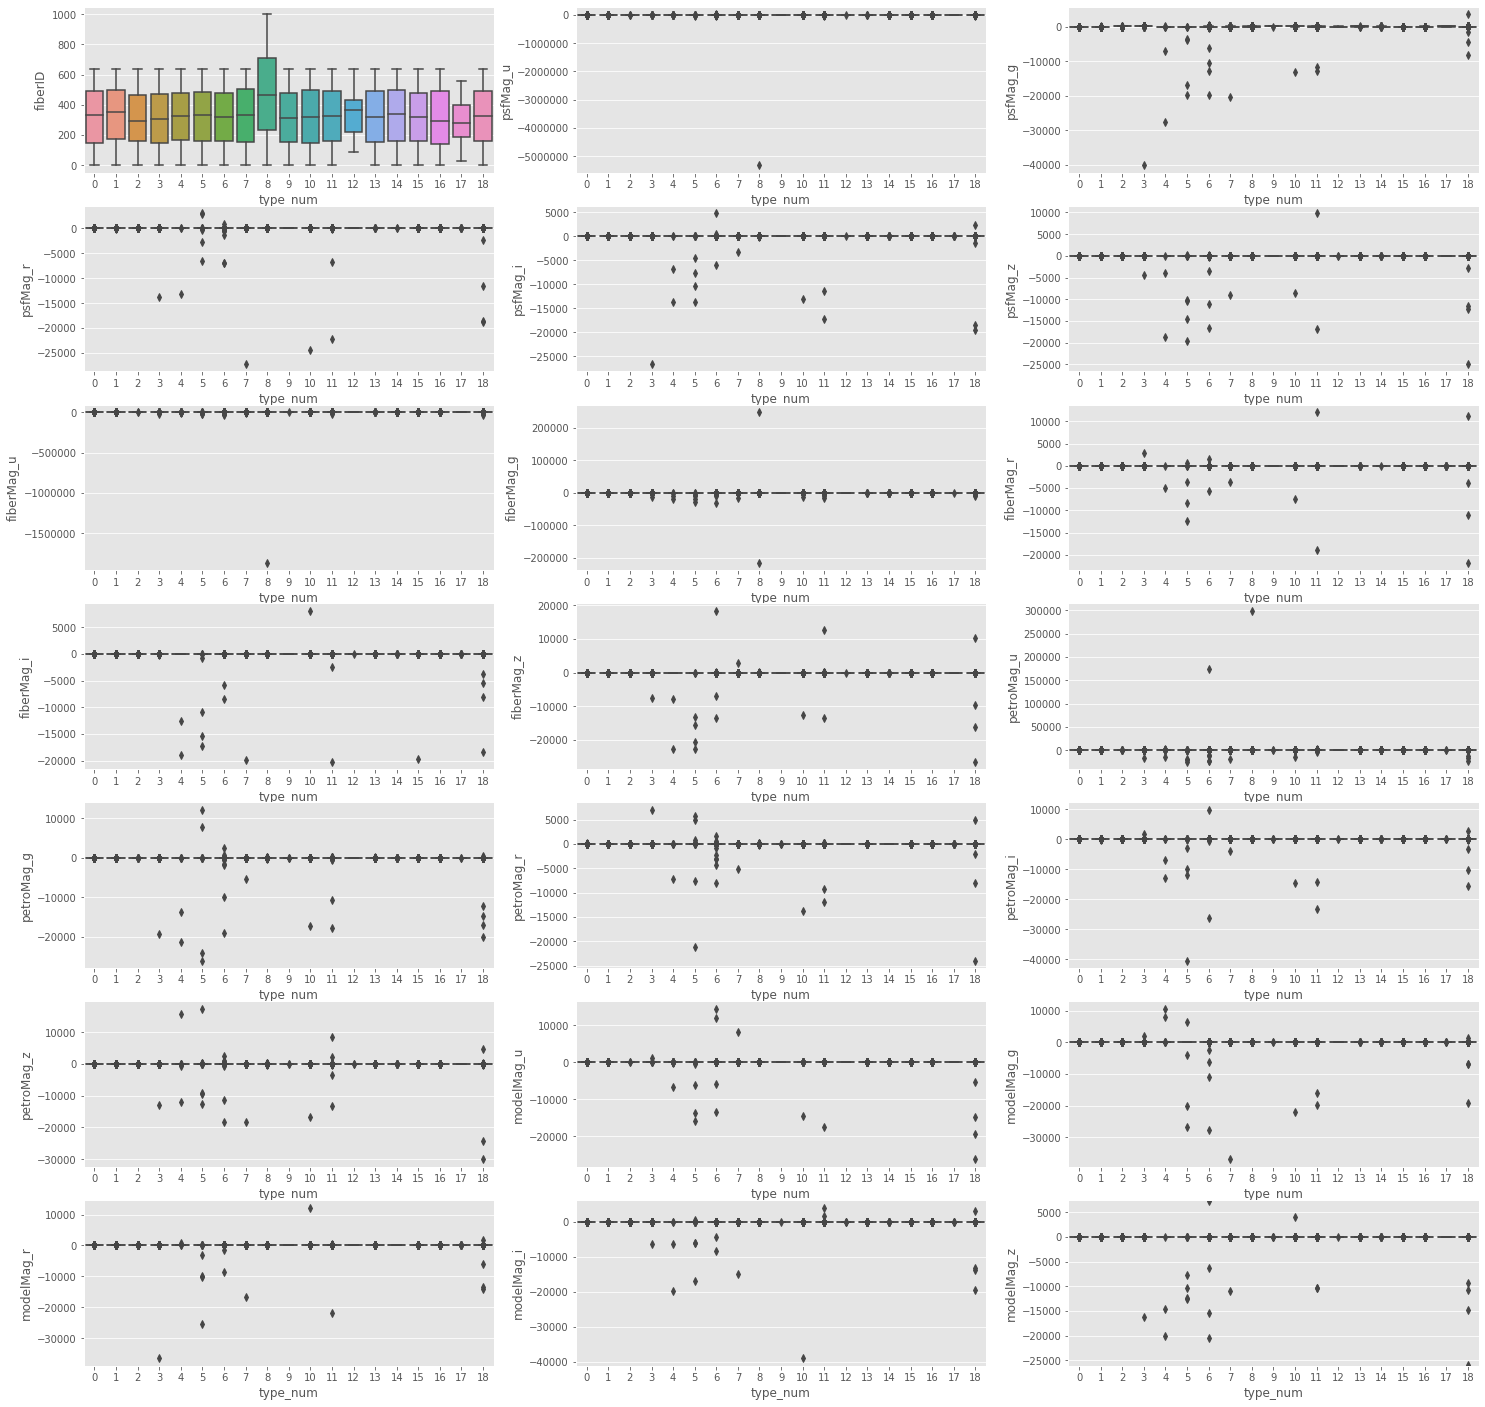

In [0]:
show_boxplot(X_train,y_train)

In [0]:
X=pd.concat([X_train,X_test],axis=0)

In [0]:
non_outlier_index=find_outlier(X)
drop_index=X.drop(non_outlier_index,axis=0).index
test_outlier_index=drop_index[drop_index>199990]
train_outlier_index=drop_index[drop_index<=199990]

In [0]:
X_nan=outlier_preprocessing(X)

In [0]:
X_nan_train=X_nan.iloc[:199991].copy()
X_nan_test=X_nan.iloc[199991:].copy()

In [0]:
X_nan_train['type_num']=y_train

In [0]:
X_train=X_nan_train.groupby('type_num').transform(lambda x:x.fillna(x.mean()))

In [0]:
X_train

,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
id,,,,,,,,,,,,,,,,,,,,,
0,601,23.198224,21.431953,21.314148,21.176553,21.171444,22.581309,21.644453,21.657571,21.387653,21.572827,22.504317,21.431636,21.478312,21.145409,20.422446,22.749241,21.465534,21.364187,21.020605,21.147340
1,788,21.431355,20.708104,20.678850,20.703420,20.473229,21.868797,21.029773,20.967054,20.937731,21.063646,21.360701,20.778968,20.889705,20.639812,20.646660,21.492955,20.758527,20.753925,20.693389,20.512314
2,427,17.851451,16.727898,16.679677,16.694640,16.641788,18.171890,17.033098,16.999682,17.095999,17.076449,17.867253,16.738784,16.688874,16.744210,16.808006,17.818063,16.697434,16.641249,16.660177,16.688928
3,864,20.789900,20.040371,19.926909,19.843840,19.463270,21.039030,20.317165,20.217898,20.073852,19.794505,20.433907,19.993727,19.985531,19.750917,19.455117,20.770711,20.001699,19.889798,19.758113,19.552855
4,612,26.454969,23.058767,21.471406,19.504961,18.389096,25.700632,23.629122,21.742750,19.861718,18.810375,25.859229,22.426929,21.673551,19.610012,18.376141,24.877052,23.147993,21.475342,19.487330,18.375655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199986,568,20.630780,20.437920,20.050756,20.020974,19.959646,20.948519,20.726709,20.311562,20.323418,20.211336,20.836400,20.536338,20.126561,20.102815,19.796722,20.783295,20.326879,20.014046,20.061940,19.862513
199987,362,25.283695,22.807243,21.069792,20.187531,19.595598,26.677671,22.818723,20.786120,19.961857,19.457071,28.895442,22.250489,20.091693,18.985791,18.803354,26.921903,21.952440,19.776321,18.990039,18.528306
199988,146,23.609826,21.902709,20.330747,18.457535,17.326771,24.320816,22.287946,20.711737,18.810560,17.721928,25.982378,22.132993,20.329624,18.507337,17.418521,24.503460,21.897599,20.420524,18.443126,17.331724


In [0]:
X_test

,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
id,,,,,,,,,,,,,,,,,,,,,
199991,251,23.817399,22.508963,20.981106,18.517316,17.076079,25.053890,23.167848,21.335901,18.835858,17.434384,22.246697,22.796239,21.195315,18.584486,17.154284,25.391534,22.499435,21.011918,18.499341,17.091474
199992,386,22.806983,21.937111,20.335770,20.000512,19.527369,22.498565,22.186000,20.618879,20.301204,20.030078,21.729831,21.837511,20.196128,19.967204,19.683671,22.475338,21.853442,20.173169,19.796757,19.567372
199993,232,21.024250,19.235669,18.304061,17.808608,17.380113,21.205546,19.439533,18.344433,17.909690,17.538164,20.722629,18.710223,17.611851,17.158519,16.843986,20.579314,18.653338,17.562108,17.120529,16.708748
199994,557,20.503424,20.286261,20.197204,20.162419,20.059832,20.976132,20.611498,20.567262,20.479318,20.277472,20.329269,20.385262,20.129157,20.206574,20.212342,20.479879,20.280943,20.150499,20.206221,20.092909
199995,75,24.244851,22.668237,21.239333,19.284777,18.235939,25.681860,22.935289,21.642456,19.624926,18.591749,22.308298,22.957496,21.285033,19.299120,18.307526,25.489360,22.857290,21.191862,19.237964,18.280368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209995,389,19.765035,19.542406,19.439286,19.357957,19.357305,20.093308,19.827172,19.714033,19.686861,19.809697,19.882728,19.549257,19.457564,19.303361,19.483389,19.792181,19.536518,19.432463,19.376445,19.354976
209996,247,19.960030,19.609379,19.325949,19.391290,19.258862,20.319914,19.928523,19.696262,19.763771,19.407112,20.085454,19.635609,19.381924,19.460517,19.390865,20.066552,19.604800,19.334113,19.401240,19.159412
209997,941,21.221899,20.276182,20.090775,19.927208,19.766732,21.254454,20.551190,20.365800,20.200872,19.930425,20.998020,20.315201,20.236725,20.058801,19.988363,21.045501,20.255485,20.141549,19.906014,19.953932


In [0]:
X=pd.concat([X_train,X_test],axis=0)

In [0]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X)
X_s=scaler.transform(X)

In [0]:
pca=PCA(15,whiten=True,random_state=72)

In [0]:
X_p=pca.fit_transform(X_s)
X_p=pd.DataFrame(X_p)

In [0]:
X_train=X_p.iloc[:199991]
X_test=X_p.iloc[199991:]

In [0]:
from sklearn.model_selection import train_test_split
X_train_small,X_val,y_train_small,y_val = train_test_split(X_train,y_train,stratify=y_train,test_size=0.08,random_state=240)

In [0]:
from keras import layers
from keras import models
from keras import optimizers
from keras import regularizers
from keras import initializers
model=keras.models.Sequential()
model.add(layers.Dense(512,activation='relu',input_shape=(15,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(19,activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 19)                9747      
Total params: 280,595
Trainable params: 280,595
Non-trainable params: 0
_________________________________________________________________


In [29]:
from keras.callbacks import EarlyStopping,ModelCheckpoint
early_stop=EarlyStopping(patience=100,verbose=1)
model_check=ModelCheckpoint('best_model.h22',monitor='val_loss',mode='min',save_best_only=True)
model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizers.Adagrad(),metrics=['acc'])
history=model.fit(X_train_small,y_train_small,epochs=10000,batch_size=128,callbacks=[early_stop,model_check],validation_data=(X_val,y_val))


Train on 183991 samples, validate on 16000 samples
Epoch 1/10000
183991/183991 [==============================] - 7s 38us/step - loss: 0.6546 - acc: 0.7987 - val_loss: 0.4989 - val_acc: 0.8401
Epoch 2/10000
183991/183991 [==============================] - 5s 28us/step - loss: 0.5480 - acc: 0.8259 - val_loss: 0.4700 - val_acc: 0.8428
Epoch 3/10000
183991/183991 [==============================] - 5s 26us/step - loss: 0.5190 - acc: 0.8344 - val_loss: 0.4544 - val_acc: 0.8494
Epoch 4/10000
183991/183991 [==============================] - 5s 27us/step - loss: 0.5010 - acc: 0.8384 - val_loss: 0.4440 - val_acc: 0.8518
Epoch 5/10000
183991/183991 [==============================] - 5s 27us/step - loss: 0.4917 - acc: 0.8407 - val_loss: 0.4374 - val_acc: 0.8533
Epoch 6/10000
183991/183991 [==============================] - 5s 27us/step - loss: 0.4842 - acc: 0.8420 - val_loss: 0.4307 - val_acc: 0.8564
Epoch 7/10000
183991/183991 [==============================] - 5s 26us/step - loss: 0.4765 - acc:

In [0]:
model.save('model_edge.h2022')

In [0]:
pred=model2.predict(X_test)
submission = pd.DataFrame(data=pred, columns=sample_submission.columns, index=sample_submission.index)
submission.to_csv('submissionh20.csv', index=True)

NameError: ignored

batch_size : 128


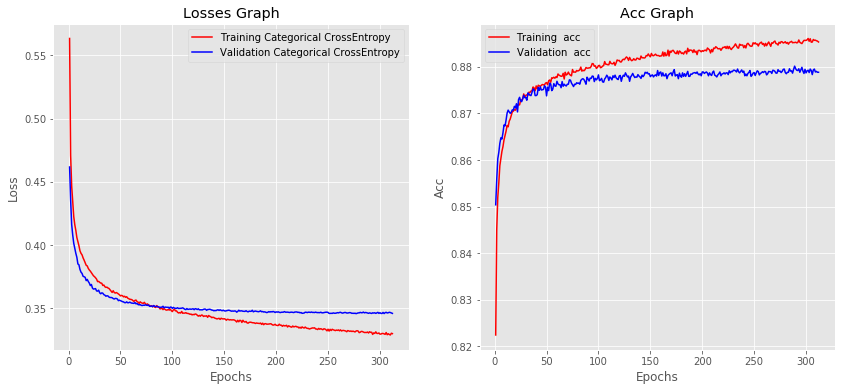

In [0]:
plot_loss(history)
#h20,h2021 0.3 0.5

In [0]:
y_pred=model.predict(X_train)

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_train,y_pred_arg))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.49      0.51      0.50      2160
           1       0.97      0.96      0.96      6506
           2       0.74      0.54      0.62       500
           3       0.81      0.88      0.84      2562
           4       0.92      0.97      0.95     14618
           5       0.85      0.93      0.89     13500
           6       0.97      0.99      0.98     37347
           7       0.58      0.53      0.55      4654
           8       0.93      0.90      0.91     49680
           9       0.95      0.94      0.95       127
          10       0.97      0.97      0.97     13750
          11       0.69      0.36      0.47      6580
          12       1.00      0.08      0.14        13
          13       0.79      0.63      0.70      7132
          14       0.84      0.97      0.90      3257
          15       0.95      0.97      0.96     14630
          16       0.92      0.96      0.94      1154
          17       0.00    

In [0]:
from keras.models import load_model
model2 = load_model('best_model.h22')

In [0]:
before=model2.predict(X_test)